#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch import optim, nn

from tqdm import tqdm

#### Load data and create loaders

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

#### Architecture

In [3]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(64, 10)
        
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.logsoftmax(x)
        
        return x

In [4]:
model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax(dim=1)
)

In [5]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [6]:
epochs = 20

In [7]:
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")
        torch.save(model.state_dict(),'simple_mnist_ep_'+str(e+1)+'.pt')

Training loss: 1.0617855030145726
Training loss: 0.3861854198073019
Training loss: 0.3232037104459714
Training loss: 0.293030379002473
Training loss: 0.2682478198968271
Training loss: 0.24751203737930574
Training loss: 0.22836767053251456
Training loss: 0.21104525907763413
Training loss: 0.1953515586957558
Training loss: 0.18063598366847425
Training loss: 0.16849193752193248
Training loss: 0.15750179047197865
Training loss: 0.1479668528008372
Training loss: 0.13896057770442544
Training loss: 0.13107377534478046
Training loss: 0.12452973411885152
Training loss: 0.11765689041608496
Training loss: 0.11186736544320133
Training loss: 0.10660934416172124
Training loss: 0.10151058428092742


#### Load weights and compute NP, EP (layer-wise)

In [8]:
from topological_nn_measures import layer_neural_persistence

In [9]:
m_inter = Network()

In [22]:
nLayers = 3
nBins = 10

EPs = np.zeros((epochs,nLayers))
NPs = np.zeros((epochs,nLayers))

w1_hist = np.zeros((epochs,nBins))
w2_hist = np.zeros((epochs,nBins))
w3_hist = np.zeros((epochs,nBins))

for ii in tqdm(range(epochs)):
    
    m_inter = torch.load('simple_mnist_ep_'+str(ii+1)+'.pt')
    
    w1 = m_inter['fc1.weight'].numpy().T
    w2 = m_inter['fc2.weight'].numpy().T
    w3 = m_inter['fc3.weight'].numpy().T
    
    EPs[ii,0], _ = layer_neural_persistence(w1,'EP',False)
    EPs[ii,1], _ = layer_neural_persistence(w2,'EP',False)
    EPs[ii,2], _ = layer_neural_persistence(w3,'EP',False)
    
    NPs[ii,0], _ = layer_neural_persistence(w1,'NP',False)
    NPs[ii,1], _ = layer_neural_persistence(w2,'NP',False)
    NPs[ii,2], _ = layer_neural_persistence(w3,'NP',False)
    
    w1_hist[ii], w1_bin_edges = np.histogram(w1, bins=nBins, density=True)
    w2_hist[ii], w2_bin_edges = np.histogram(w2, bins=nBins, density=True)
    w3_hist[ii], w3_bin_edges = np.histogram(w3, bins=nBins, density=True)

100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


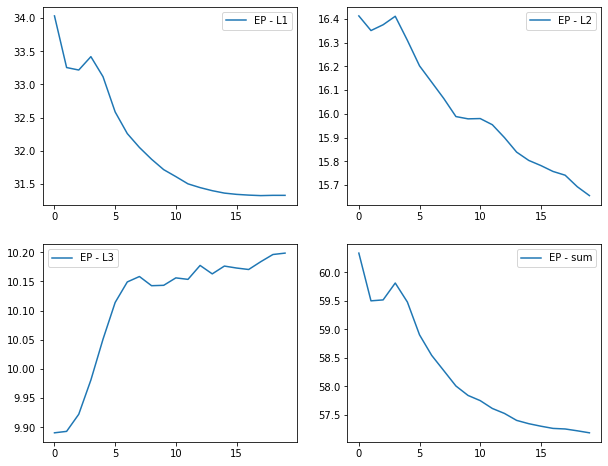

In [23]:
ff1 = plt.figure(figsize=(10,8))

plt.subplot(221)
plt.plot(EPs[:,0],label='EP - L1')
plt.legend()

plt.subplot(222)
plt.plot(EPs[:,1],label='EP - L2')
plt.legend()

plt.subplot(223)
plt.plot(EPs[:,2],label='EP - L3')
plt.legend()

plt.subplot(224)
plt.plot(np.sum(EPs,axis=-1),label='EP - sum')
plt.legend()

plt.show()

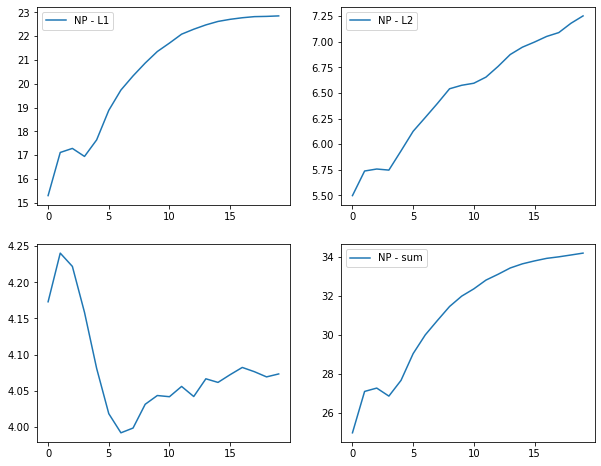

In [24]:
ff2 = plt.figure(figsize=(10,8))

plt.subplot(221)
plt.plot(NPs[:,0],label='NP - L1')
plt.legend()

plt.subplot(222)
plt.plot(NPs[:,1],label='NP - L2')
plt.legend()

plt.subplot(223)
plt.plot(NPs[:,2],label='NP - L3')

plt.subplot(224)
plt.plot(np.sum(NPs,axis=-1),label='NP - sum')
plt.legend()

plt.show()